## Task
**Find out weather person is merrid**. (*filed S2*)

It is first homework for [interpretable machine learning](https://github.com/pbiecek/InterpretableMachineLearning2018S/tree/master/PraceDomowe/PD1).
### Data
From a study [about relationships](https://flowingdata.com/2019/02/26/probability-you-will-break-up-with-your-partner/).
* [Project site and link to data](https://data.stanford.edu/hcmst2017)
* [Columns description](https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(124)

In [0]:
!wget -O - 'http://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip' > HCMST.zip
!unzip HCMST.zip 
!mv 'HCMST 2017 fresh sample for public sharing draft v1.1.dta' HCMST.dta

URL transformed to HTTPS due to an HSTS policy
--2019-03-17 20:27:58--  https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463647 (453K) [application/zip]
Saving to: ‘STDOUT’

-                   100%[===================>] 452.78K  2.22MB/s    in 0.2s    

2019-03-17 20:27:58 (2.22 MB/s) - written to stdout [463647/463647]

Archive:  HCMST.zip
  inflating: HCMST 2017 fresh sample for public sharing draft v1.1.dta  


In [0]:
raw_data = pd.read_stata('HCMST.dta')

In [0]:
selected_cols = {
    'ppage': 'age', 
    'ppincimp': 'hausehold_income', 
    'ppp20072': 'religion', 
#    'w6_how_many_2': 'different_partners_ly' -- only 2% filedes has not nan value
#    'Q32_2': 'meet_in_internet' -- only 15% data all in not-merried
    'Q25': 'same_high_school'
}
predict_col = {'S1': 'merried'}

data = raw_data[list(selected_cols.keys()) + list(predict_col.keys())]
data = data.rename(selected_cols, axis='columns')
data = data.rename(predict_col, axis='columns')

data.head()

#['partner age','are you same sex','partner education','age', 'Q27: How often do you attend religious services?', 'Did you and [Partner name] attend the same high school?', 'Same university/colage']
#['Q9', 'Q5', 'Q10', 'ppage', 'ppp20072', 'Q25', 'Q26']
# Q23 who earnd more in 2016
# ppgender gendeer

# Q32_2 Did you use an Internet service to meet [Partner name]? 
# w6_how_many_2 byte %8.0g V155_A
#  How many Different people have you met for dating, or romance, or sex in the pas
# w6_q19 byte %8.0g Q19 Are you currently living wit
# Q21A_2_Year Year you first met the partner

,age,hausehold_income,religion,same_high_school,merried
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married"
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married"
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married"
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married"


In [0]:
religion_cat = pd.api.types.CategoricalDtype(
    categories=['Never', 'Once a year or less', 'A few times a year',
                'Once or twice a month', 'Once a week', 'More than once a week'],
    ordered=True)

income_cat = pd.api.types.CategoricalDtype(
    categories=['Less than $5,000', '$5,000 to $7,499', '$7,500 to $9,999',
                '$10,000 to $12,499', '$12,500 to $14,999', '$15,000 to $19,999',
                '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $34,999',
                '$35,000 to $39,999', '$40,000 to $49,999', '$50,000 to $59,999',
                '$60,000 to $74,999', '$75,000 to $84,999', '$85,000 to $99,999',
                '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $174,999',
                '$175,000 to $199,999', '$200,000 to $249,999', '$250,000 or more'],
    ordered=True)

data['age'] = data['age'].astype('int')
#data['hausehold_income'] = data['hausehold_income'].astype(income_cat)
#data['religion'] = data['religion'].astype(religion_cat)

In [0]:
# średnia wartość w przedziale
income_conv = {
    'Less than $5,000': 2.5, 
    '$5,000 to $7,499': 6.25, 
    '$7,500 to $9,999': 8.75,
    '$10,000 to $12,499': 11.25, 
    '$12,500 to $14,999': 13.75, 
    '$15,000 to $19,999': 17.5,
    '$20,000 to $24,999': 22.5, 
    '$25,000 to $29,999': 27.5, 
    '$30,000 to $34,999': 32.5,
    '$35,000 to $39,999': 37.5, 
    '$40,000 to $49,999': 45, 
    '$50,000 to $59,999': 55,
    '$60,000 to $74,999': 67.5, 
    '$75,000 to $84,999': 80, 
    '$85,000 to $99,999': 92.5,
    '$100,000 to $124,999': 112.5, 
    '$125,000 to $149,999': 137.5, 
    '$150,000 to $174,999': 162.5,
    '$175,000 to $199,999': 182.5, 
    '$200,000 to $249,999': 225, 
    '$250,000 or more': 275,       # trudno znaleźć wartość między nieskończonością
}

religion_conv = { religion_cat.categories[i]: i for i in range(len(religion_cat.categories)) }

high_school_conv = { 
    'Same High School': 1, 
    'Different High School': 0,
    np.NaN: 0
}

merried_conv = {
    'No, I am not Married': 0,
    'Yes, I am Married': 1
}


In [0]:
for (name, m) in (('religion', religion_conv), 
                  ('same_high_school', high_school_conv),
                  ('hausehold_income', income_conv),
                  ('merried', merried_conv),):
    data[name + '_val'] = data[name].map(m)

data.head()

,age,hausehold_income,religion,same_high_school,merried,religion_val,same_high_school_val,hausehold_income_val,merried_val
0,30,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,0.0,45.0,0
1,55,"$150,000 to $174,999",Never,Different High School,"Yes, I am Married",0.0,0.0,162.5,1
2,47,"$200,000 to $249,999",Once or twice a month,Different High School,"Yes, I am Married",3.0,0.0,225.0,1
3,28,"$40,000 to $49,999",Never,NaN,"No, I am not Married",0.0,0.0,45.0,0
4,59,"$175,000 to $199,999",Once a year or less,Different High School,"Yes, I am Married",1.0,0.0,182.5,1


In [0]:
use_columns, predict_columns = (['age', 'hausehold_income_val', 'religion_val', 'same_high_school_val'], 'merried_val')

data.dtypes

age                        int64
hausehold_income        category
religion                category
same_high_school        category
merried                 category
religion_val             float64
same_high_school_val     float64
hausehold_income_val     float64
merried_val                int64
dtype: object

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data[use_columns + [predict_columns]].dropna(), test_size=0.2)
test.head()

,age,hausehold_income_val,religion_val,same_high_school_val,merried_val
2236,51,22.5,4.0,0.0,0
369,61,137.5,4.0,0.0,1
1358,56,37.5,5.0,0.0,1
318,57,37.5,2.0,0.0,0
3394,35,112.5,0.0,0.0,1


In [0]:
train_X = train[use_columns]
train_y = train[predict_columns]
test_X = test[use_columns]
test_y = test[predict_columns]

In [0]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=20)
trained = model.fit(train_X, train_y)

print("Train score: " + str(trained.score(train_X, train_y)))
print("Test score: " + str(trained.score(test_X, test_y)))

Train score: 0.7585059171597633
Test score: 0.7100591715976331


 ## Interpreting the model predictions
 First some instance-level explanations of model decisions.
 We will choose random person from test dataset and analise what determined model decision.

In [0]:
# Wybrana osoba:
persons = [669, 1152, 2236, 130]

data.loc[persons]

,age,hausehold_income,religion,same_high_school,merried,religion_val,same_high_school_val,hausehold_income_val,merried_val
669,22,"$100,000 to $124,999",Once or twice a month,NaN,"No, I am not Married",3.0,0.0,112.5,0
1152,30,"$60,000 to $74,999",Once a week,Different High School,"No, I am not Married",4.0,0.0,67.5,0
2236,51,"$20,000 to $24,999",Once a week,NaN,"No, I am not Married",4.0,0.0,22.5,0
130,75,"$35,000 to $39,999",Once a week,Different High School,"Yes, I am Married",4.0,0.0,37.5,1


### Ceteris Paribus Profiles *(what-ifs)*
First we will plot the Cetreris Paribus Profiles for given person. That way we will check what would be model prediction if we changed wan input variable and left the rest unchanged.

In [0]:
def predict_with_changed(column, values, model=trained, instance=input_person):
    """ Calculates predictions for given instance with changed values of column.
        Uses provided values and 
    """
    spectrum = []
    for i in range(len(values)):
        obj = instance.copy();
        obj[column] = values[i]
        spectrum.append(obj)
    return model.predict_proba(spectrum)

In [0]:
def plot_cpp(column, values, model=trained, instance=input_person,title=None, x_values=None, hlines=None):
    # setting default values
    if title is None:
        title = 'Changing column "' + column
        if x_values is None:
            title += '" (' + str(instance[column]) + ')'
        else:
            title += '" (' + str(x_values[int(instance[column])]) + ')'
    if x_values is None:
        x_values = values
    if hlines is None:
        hlines = [0.5]
        
    # getting predictions for changed values
    spectrum  = predict_with_changed(column, values, model, instance)
    real_pred = trained.predict_proba([instance])[0][1]
    real_val  = instance[column]
    
    # plotting results
    plt.ylim(0,1)
    plt.title(title)
    plt.hlines(hlines, values[0], values[-1], '0.5', 'dashed')
    plt.plot(x_values, spectrum[:,1])
    plt.plot(real_val, real_pred, 'ro')
    

In [0]:
def plot_person(index):
    person = data.loc[index]
    parsed_person = data.loc[index].copy()
    parsed_person['pred_merried'] = trained.predict([data.loc[index][use_columns]])[0]
    parsed_person['pred_proba_meried'] = trained.predict_proba([data.loc[index][use_columns]])[0][1]
    
    input_person = parsed_person[use_columns]
    
    plt.figure(figsize=(20,10))
    plt.suptitle('Ceteris Paribus Profiles (' + parsed_person['merried'] + ')', fontsize=18)

    plt.subplot(2, 2, 1)
    plot_cpp('age', range(18, 90), instance=input_person)

    plt.subplot(2, 2, 2)
    plot_cpp('hausehold_income_val', list(income_conv.values()), instance=input_person)

    plt.subplot(2, 2, 3)
    plot_cpp('religion_val', list(religion_conv.values()),x_values=list(religion_conv.keys()), instance=input_person)

    plt.subplot(2, 2, 4)
    hs_spectrum = predict_with_changed('same_high_school_val',[0,1], instance=input_person)
    plt.ylim(0,1)
    plt.title("changing high school (" + str(parsed_person["same_high_school"]) + ")")
    plt.hlines(0.5, -1, 2, '0.5', 'dashed')
    bars = plt.bar(["Different high school or NaN","Same high school"], hs_spectrum[:,1])
    bars[int(input_person["same_high_school_val"])].set_color('r')
    

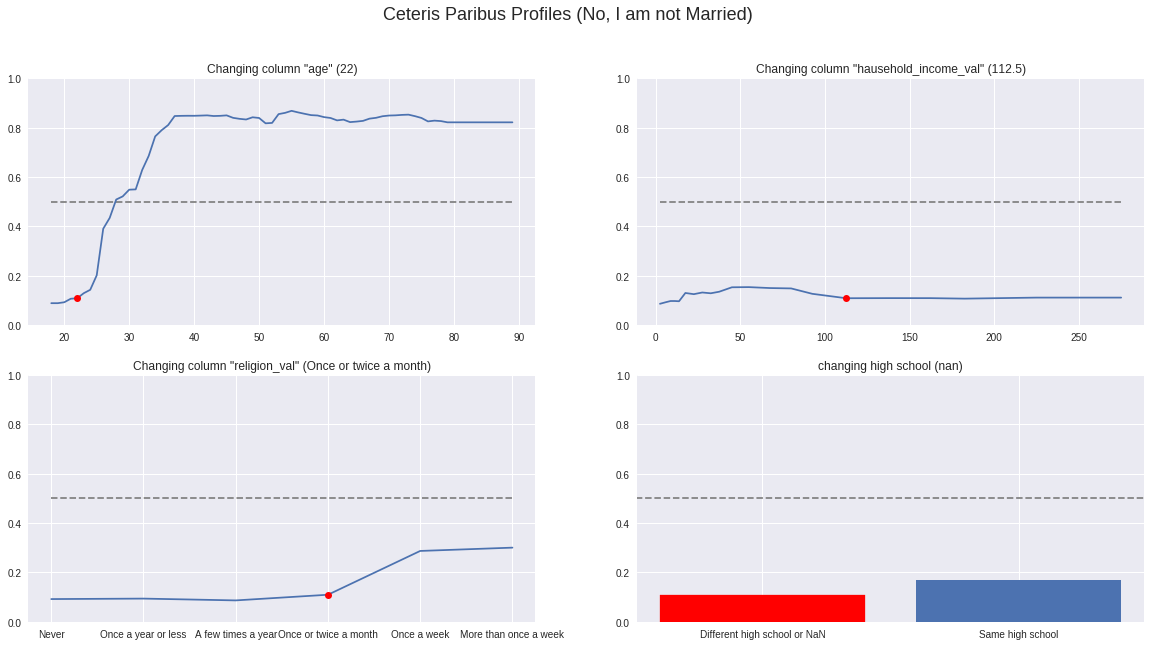

In [0]:
plot_person(persons[0])

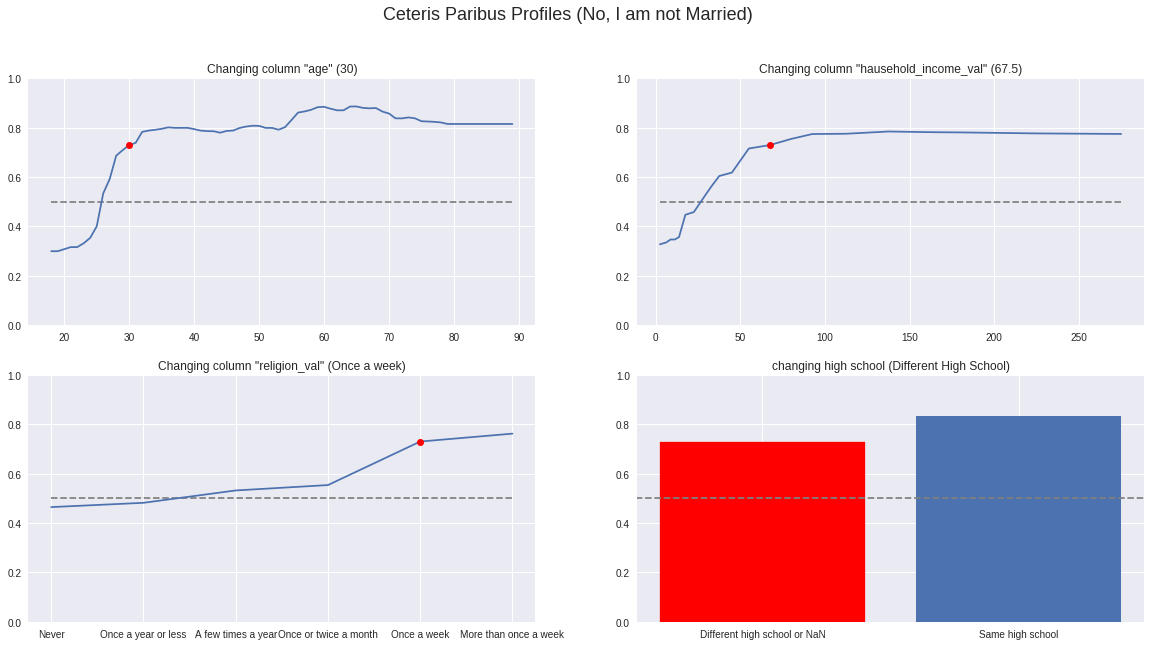

In [0]:
plot_person(persons[1])

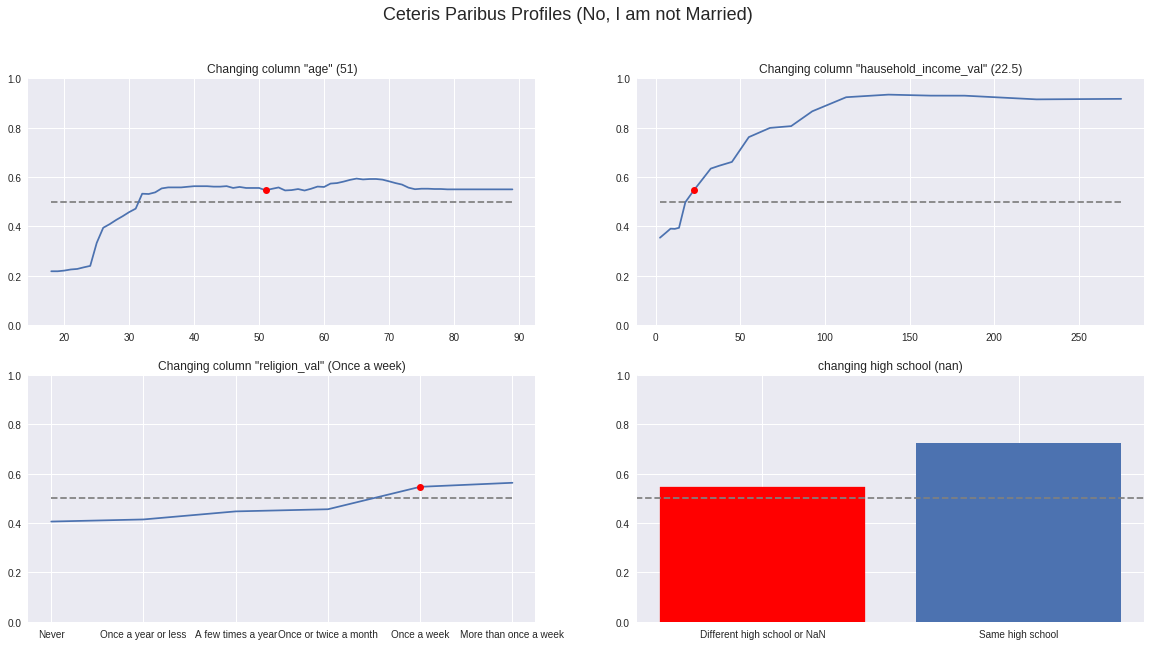

In [0]:
plot_person(persons[2])

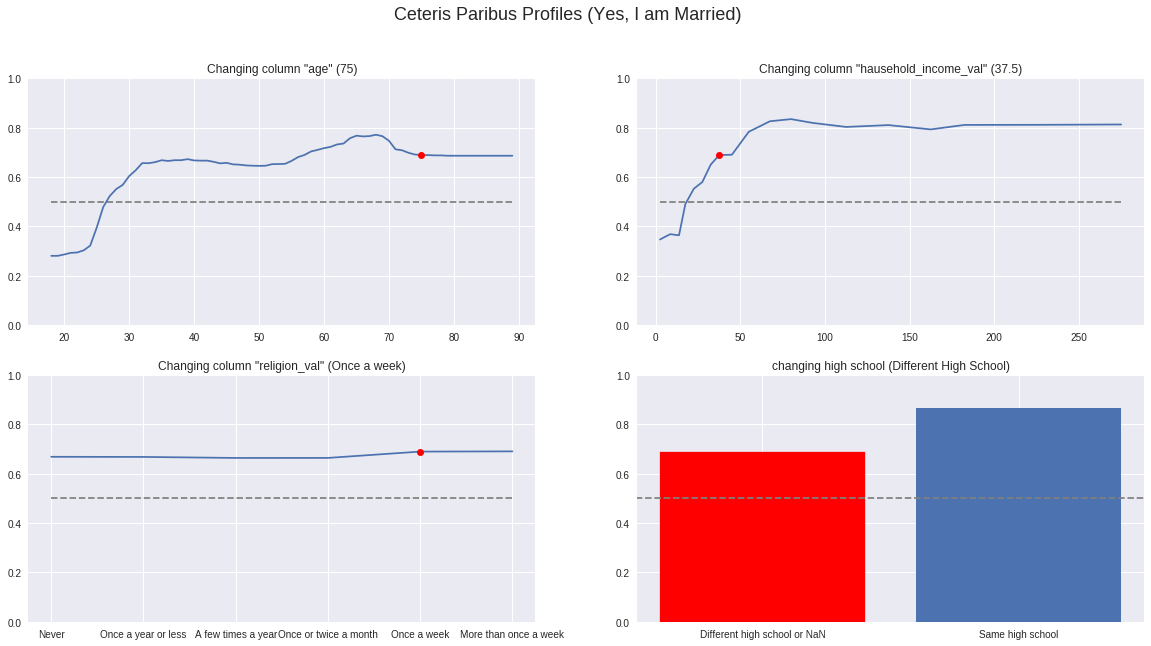

In [0]:
plot_person(persons[3])